In [19]:
# %%
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
# %%
# Load the dataset
data = pd.read_csv("/Users/rooj/Documents/RP3-Main/RP3-Data/CSE-CIC-IDS2018/DoS-Related/02-15-2018.csv")

# Preview the dataset
print(data.head())
print(data.info())
print(data['Label'].value_counts())

   Dst Port  Protocol            Timestamp  Flow Duration  Tot Fwd Pkts  \
0         0         0  15/02/2018 08:25:18      112641158             3   
1        22         6  15/02/2018 08:29:05       37366762            14   
2     47514         6  15/02/2018 08:29:42            543             2   
3         0         0  15/02/2018 08:28:07      112640703             3   
4         0         0  15/02/2018 08:30:56      112640874             3   

   Tot Bwd Pkts  TotLen Fwd Pkts  TotLen Bwd Pkts  Fwd Pkt Len Max  \
0             0                0                0                0   
1            12             2168             2993              712   
2             0               64                0               64   
3             0                0                0                0   
4             0                0                0                0   

   Fwd Pkt Len Min  ...  Fwd Seg Size Min  Active Mean     Active Std  \
0                0  ...                 0          0.0 

In [21]:
# %%
# Step 1: Map labels to integers
label_mapping = {'Benign': 0, 'DoS attacks-GoldenEye': 1, 'DoS attacks-Slowloris': 2}
data['Label'] = data['Label'].map(label_mapping)

# Filter for relevant classes
data = data[data['Label'].isin([0, 1, 2])]

print("Class distribution:\n", data['Label'].value_counts())

Class distribution:
 Label
0    996077
1     41508
2     10990
Name: count, dtype: int64


In [22]:
# %%
# Step 2: Select relevant features for clustering
selected_features = ['Flow Duration', 'Fwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Pkt Size Avg', 'Flow IAT Mean']
X = data[selected_features]
y = data['Label']  # True labels for evaluation

# Step 3: Handle missing values
X = X.dropna()

# Step 4: Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [23]:
# Step 5: Initialize cluster centres using labeled data
labeled_data = data.groupby('Label').apply(lambda group: group.sample(5, random_state=42))  # Sample 5 points per label
labeled_indices = labeled_data.index.get_level_values(1)  # Extract the second level of the multi-index (row indices)
X_labeled = X_scaled[labeled_indices]
y_labeled = y.iloc[labeled_indices]

unique_labels = np.unique(y_labeled)
initial_centers = np.array([X_labeled[y_labeled == label].mean(axis=0) for label in unique_labels])



In [24]:
# %%
# Step 6: Run K-Means clustering with predefined initial centers
kmeans = KMeans(n_clusters=len(unique_labels), init=initial_centers, n_init=1, random_state=42)
kmeans.fit(X_scaled)

# Retrieve cluster assignments
cluster_labels = kmeans.labels_


In [28]:
# %%
# Step 7: Evaluate clustering using a sample of the data
# Define the sample size
sample_size = 50000  # Adjust the sample size as needed
sample_indices = np.random.choice(X_scaled.shape[0], size=sample_size, replace=False)

# Sample data for evaluation
X_sampled = X_scaled[sample_indices]
cluster_labels_sampled = np.array(cluster_labels)[sample_indices]
y_sampled = np.array(y)[sample_indices]  # True labels (if available)

# Calculate the Silhouette Score on the sampled data
silhouette = silhouette_score(X_sampled, cluster_labels_sampled)
print(f"Silhouette Score (sampled): {silhouette}")

# Analyze cluster composition on the sampled data
data_sampled = data.iloc[sample_indices].copy()  # Create a subset of the data
data_sampled['Cluster'] = cluster_labels_sampled

# Specify the order of clusters and labels
cluster_order = sorted(data_sampled['Cluster'].unique())
label_order = sorted(data_sampled['Label'].unique())

# %%
# Align cluster labels to majority class
def align_clusters(data, cluster_labels):
    # Map clusters to their majority label
    cluster_mapping = (
        data.groupby('Cluster')['Label']
        .apply(lambda x: x.value_counts().idxmax())
        .to_dict()
    )
    
    # Map cluster labels to their aligned labels
    data['Aligned Cluster'] = data['Cluster'].map(cluster_mapping)
    return cluster_mapping, data

# For Seeded K-Means
data_sampled['Cluster'] = cluster_labels_sampled  # Original cluster labels
seeded_mapping, data_seeded = align_clusters(data_sampled, cluster_labels_sampled)
print("Cluster Mapping (Seeded):", seeded_mapping)

cluster_composition_seeded = (
    data_seeded.groupby('Aligned Cluster')['Label']
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
)
print("Cluster Composition (Aligned - Seeded):\n", cluster_composition_seeded)

Silhouette Score (sampled): 0.6583268435225207
Cluster Mapping (Seeded): {0: 0, 1: 0, 2: 0}
Cluster Composition (Aligned - Seeded):
 Label                  0        1        2
Aligned Cluster                           
0                0.94948  0.03986  0.01066


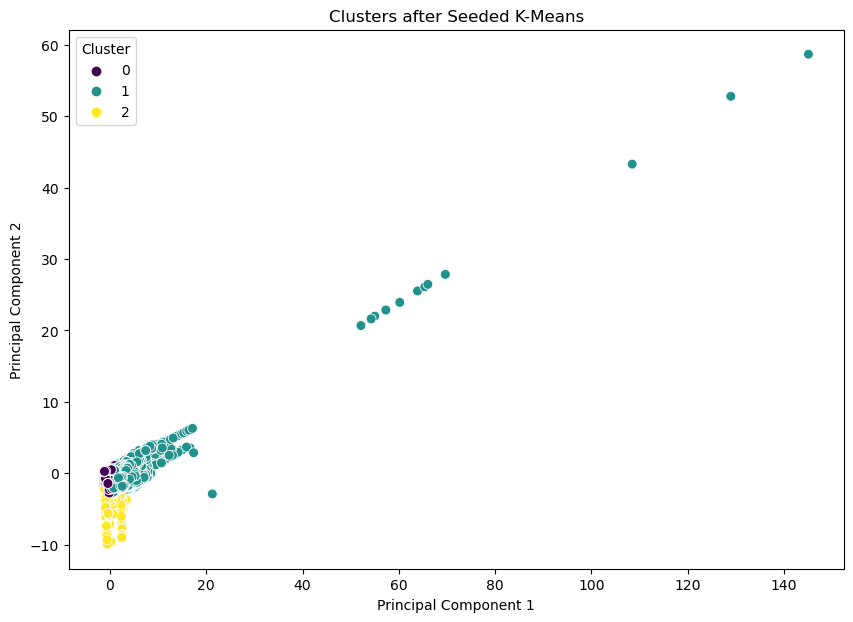

In [26]:
# %%
# Visualize clusters (if PCA reduces to 2D or 3D)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)  # Change to 3 for 3D visualization
X_pca = pca.fit_transform(X_scaled)

if X_pca.shape[1] == 2:
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='viridis', s=50)
    plt.title('Clusters after Seeded K-Means')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Cluster')
    plt.show()
elif X_pca.shape[1] == 3:
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=cluster_labels, cmap='viridis', s=50)
    ax.set_title('Clusters after Seeded K-Means')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    plt.show()


In [27]:
# %%
# Save the KMeans and scaler models
import joblib
joblib.dump(kmeans, 'seeded_kmeans_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("Models saved successfully.")

Models saved successfully.
